# **Intro linear latent space arithmetic PCA**
In this notebook I use a PCA in order to predict the gene expression changes induced by a perturbation.
Here, we want to know the cell-type specific perturbation effect.
We use unperturbed single-cell and pert+unpert bulk in order to infer the cell-type specific expressiom change.
To do this, we use latent space arithmetic, where the latent space is the PCA space. 





# **Imports**

In [48]:
# general imports
import warnings
import numpy as np
import scanpy as sc
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [49]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)
reload(vp)

<module 'buddi.plotting.validation_plotting' from '/beevol/home/davidson/checkouts/sc_bulk_ood/kang_analysis/kang_comparators/../../buddi/plotting/validation_plotting.py'>

In [50]:
## parameters
aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../../results/single_cell_data/bp_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_kang/CIBERSORTx_Job22_Results.csv"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kang/"

# bp results
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000

exp_id = "mono-kang"

RETRAIN_MODELS = False

# Set-up experimental variables

In [51]:

##################################################
#####. set up experiment specific variables
##################################################


# number of patients/domains/samples expected
n_tot_samples = 8 # 8 bulk and single cell samples

# number of drugs one-hot encoded
n_drugs = 2

# number of types of sequencing (one-hot encoded)
n_tech = 2

# experiment id
lab_file_name = exp_id


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [52]:
# read in the labeled data
X_full, Y_full, gene_df, meta_df = sc_preprocess.read_all_kang_pseudobulk_files(aug_data_path, exp_id, num_bulks_training=10)
X_full.columns = gene_df


1488
STIM
Train
Test
CTRL
Train
Test
1244
STIM
Train
Test
CTRL
Train
Test
1016
STIM
Train
Test
CTRL
Train
Test
101
STIM
Train
Test
CTRL
Train
Test
1039
STIM
Train
Test
CTRL
Train
Test
107
STIM
Train
Test
CTRL
Train
Test


In [53]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim == "STIM")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train_df = X_train_df[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -6928)[-6928:]
gene_df = gene_df.iloc[idx_top]


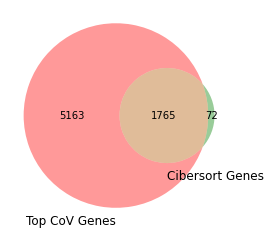

In [54]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [55]:
union_genes = np.union1d(gene_df, cibersort_genes)


# Read in BP results

In [56]:

def read_bp_result_file(res_path):
    res_file = os.path.join(res_path, "bp_expr.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [74]:

# read in BP
bp_df  = read_bp_result_file(bp_res_path)



In [75]:
# get meta data
meta_bp_df = bp_df[["cell_type", "samp_ID"]]

# join with the more detailed metadata
# we used the following index to do our analysis
# these are training samples -- i.e. used during training 
# BUT they are trained unsupervised i.e. the cell-type proportion for these samples is not known
idx_tmp = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]
idx_keep_size = len(idx_tmp)
ref_meta_df = meta_df.iloc[idx_tmp]
ref_meta_df["samp_ID"] = range(120)

# right join to maintain order 
meta_bp_df = ref_meta_df.merge(meta_bp_df, how='right', on='samp_ID')

# Y_max no longer matters for this BP sample, this is referencing the cell_type
meta_bp_df["Y_max"] = meta_bp_df["cell_type"]

# this is also all going to be used in our testing
meta_bp_df["isTraining"] = "Test"


# get the overlapping genes
bp_union_genes = np.intersect1d(bp_df.columns, union_genes) 

# subset to union genes
bp_df = bp_df.loc[:,bp_union_genes]


<ipython-input-75-00f15b9365ff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_meta_df["samp_ID"] = range(120)


In [76]:
meta_bp_df

,sample_id,stim,isTraining,cell_prop_type,samp_type,Y_max,samp_ID,cell_type
0,1488,STIM,Test,realistic,bulk,CD14_Mono,0,CD14_Mono
1,1488,STIM,Test,realistic,bulk,CD14_Mono,1,CD14_Mono
2,1488,STIM,Test,realistic,bulk,CD14_Mono,2,CD14_Mono
3,1488,STIM,Test,realistic,bulk,CD14_Mono,3,CD14_Mono
4,1488,STIM,Test,realistic,bulk,CD14_Mono,4,CD14_Mono
...,...,...,...,...,...,...,...,...
1195,107,CTRL,Test,realistic,bulk,NK,115,NK
1196,107,CTRL,Test,realistic,bulk,NK,116,NK
1197,107,CTRL,Test,realistic,bulk,NK,117,NK
1198,107,CTRL,Test,realistic,bulk,NK,118,NK


# Normalize input data

In [60]:
X_full = X_full.loc[:,bp_union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


X_cvae = X_full[idx_train,]
label_cvae = label_full[idx_train,]
bulk_cvae = bulk_full[idx_train,]
drug_cvae = drug_full[idx_train,]
y_cvae = Y_full.iloc[idx_train,]




# **Inspect BP output**

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.006s...
[t-SNE] Computed neighbors for 1200 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 2.612996
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.099182
[t-SNE] KL divergence after 500 iterations: 0.461358
(1200, 2)
(1200, 2)


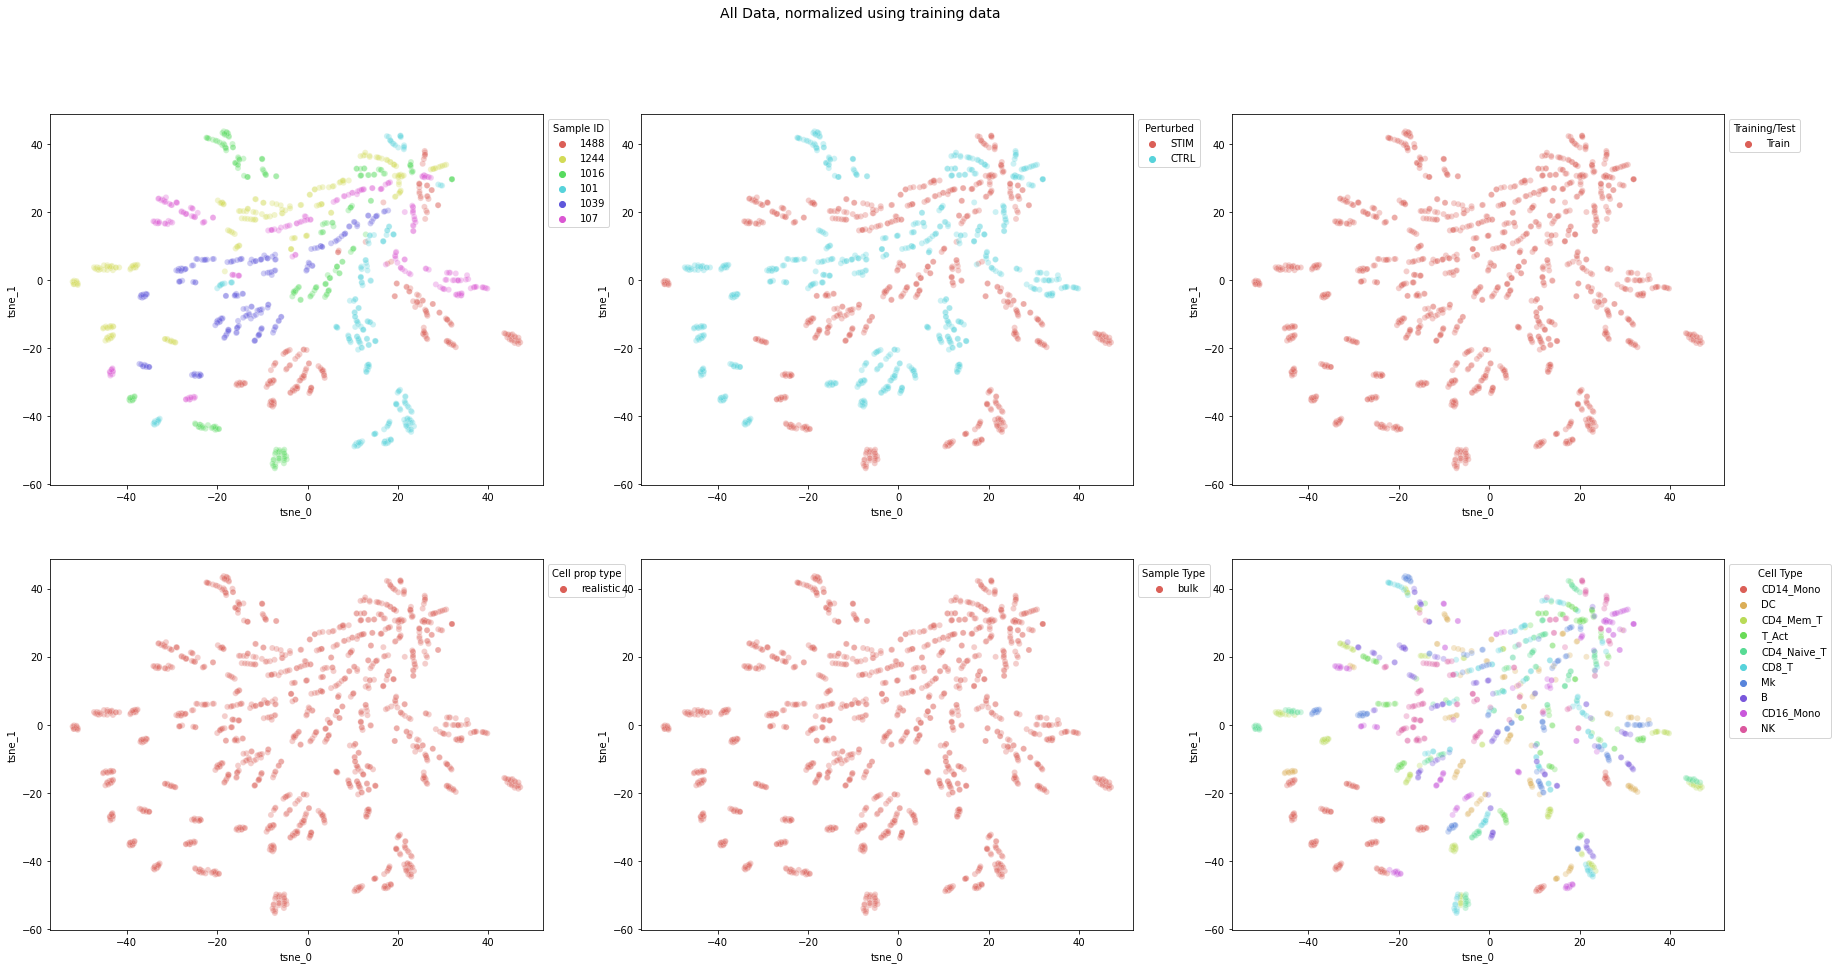

In [68]:
## plot samples
plot_df = vp.get_tsne_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_tsne(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"")
vp.plot_tsne(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"")


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


(1200, 2)
(1200, 2)


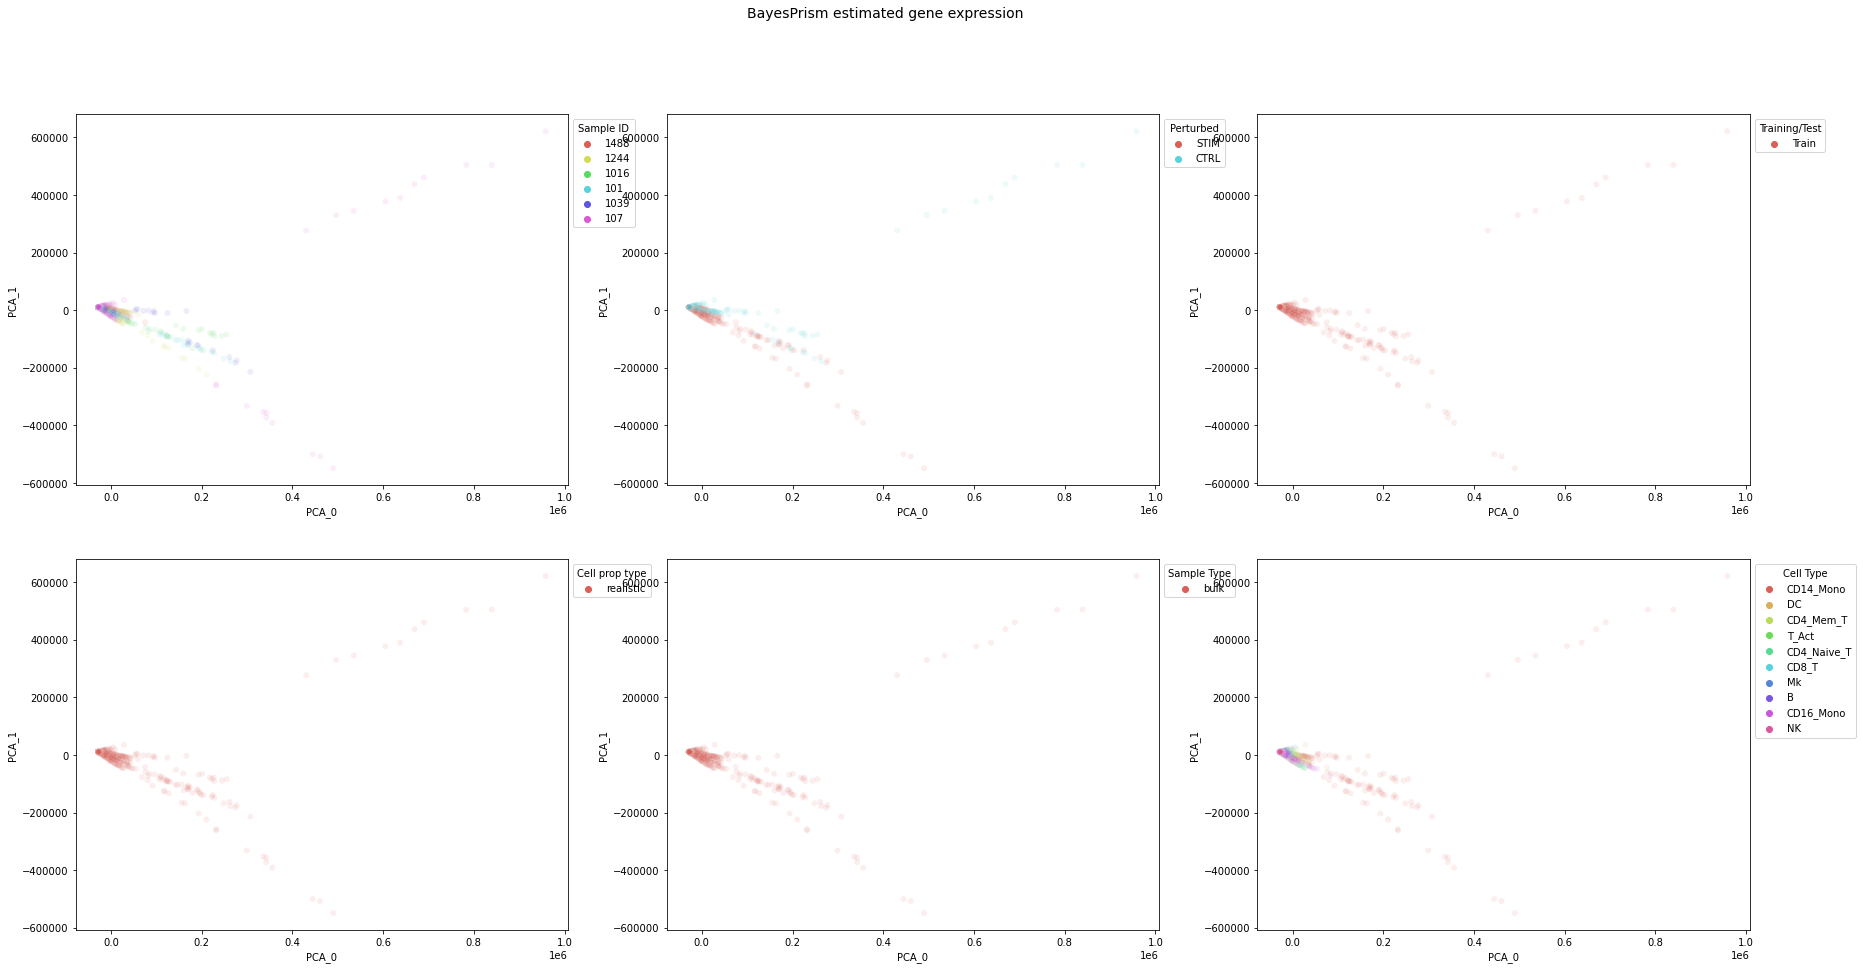

In [69]:
## plot samples
plot_df = vp.get_pca_for_plotting(bp_df)

fig, axs = plt.subplots(2, 3, figsize=(30,15))


vp.plot_pca(plot_df, meta_bp_df.sample_id.to_numpy(), axs[0,0], legend_title="Sample ID", title=f"")
vp.plot_pca(plot_df, meta_bp_df.stim.to_numpy(), axs[0,1], legend_title="Perturbed", title=f"")
vp.plot_pca(plot_df, meta_bp_df.isTraining.to_numpy(), axs[0,2], legend_title="Training/Test", title=f"")
vp.plot_pca(plot_df, meta_bp_df.cell_prop_type.to_numpy(), axs[1,0], legend_title="Cell prop type", title=f"")
vp.plot_pca(plot_df, meta_bp_df.samp_type.to_numpy(), axs[1,1], legend_title="Sample Type", title=f"")
vp.plot_pca(plot_df, meta_bp_df.cell_type.to_numpy(), axs[1,2], legend_title="Cell Type", title=f"")


fig.suptitle("BayesPrism estimated gene expression", fontsize=14)


fig.show()


## Do latent space projections

### drug perturbation

for each sample, calculate a sample projection vector and a perturbation vector. Using these two vectors we will simulate the cell- and sample-specific perturbation.

In [91]:

def subset_sample_celltype_perturbation(X_full, bp_decoded, scaler, 
                                        samp_interest, cell_prop_type, meta_df, 
                                        ctrl_test_meta_df, cell_type_interest=None):

    # get the real data
    X_tmp = np.copy(X_full)
    X_tmp = scaler.inverse_transform(X_tmp)

    # get the ground truth
    real_stimulated_idx = np.logical_and(meta_df.stim == "STIM", meta_df.isTraining == "Test")
    real_stimulated_idx = np.logical_and(real_stimulated_idx, meta_df.cell_prop_type == cell_prop_type)
    real_stimulated_idx = np.logical_and(real_stimulated_idx, meta_df.sample_id == samp_interest)

    if cell_type_interest is not None:
        real_stimulated_idx = np.logical_and(real_stimulated_idx, meta_df.Y_max == cell_type_interest)
    real_stimulated_idx = np.where(real_stimulated_idx)[0]
    real_original_stim = X_tmp[real_stimulated_idx]


    real_ctrl_idx = np.logical_and(meta_df.stim == "CTRL", meta_df.isTraining == "Test")
    real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.cell_prop_type == cell_prop_type)
    real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.sample_id == samp_interest)
    if cell_type_interest is not None:
        real_ctrl_idx = np.logical_and(real_ctrl_idx, meta_df.Y_max == cell_type_interest)
    real_ctrl_idx = np.where(real_ctrl_idx)[0]
    real_original_ctrl = X_tmp[real_ctrl_idx]


    # get the reconstructed 
    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "CTRL", ctrl_test_meta_df.isTraining == "Test")
    recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.sample_id == samp_interest)
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_ctrl = bp_decoded.iloc[recon_Zstim_idx]

    recon_Zstim_idx = np.logical_and(ctrl_test_meta_df.stim == "STIM", ctrl_test_meta_df.isTraining == "Test")
    recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.sample_id == samp_interest)
    if cell_type_interest is not None:
        recon_Zstim_idx = np.logical_and(recon_Zstim_idx, ctrl_test_meta_df.Y_max == cell_type_interest)
    recon_Zstim_idx = np.where(recon_Zstim_idx)[0]
    projected_Zstimulated = bp_decoded.iloc[recon_Zstim_idx]


    return (real_original_stim, real_original_ctrl, projected_Zstimulated, projected_ctrl)


In [92]:
curr_samp = "101"
curr_cell_type = "CD14_Mono"

real_stim, real_ctrl, proj_stim, proj_ctrl = subset_sample_celltype_perturbation(X_full, bp_df, 
                                                                                scaler, curr_samp, 
                                                                                "cell_type_specific", 
                                                                                meta_df, meta_bp_df,
                                                                                curr_cell_type)

In [94]:
proj_ctrl

,A2M,A4GALT,AAAS,AAED1,AAK1,AAMDC,AAMP,AAR2,AASDH,AASDHPPT,...,ZSCAN9,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYX,ZZZ3
70,0.076,52.228,428.916,227.764,65.352,403.728,357.608,14.964,18.724,71.144,...,0.0,37.496,72.868,234.060,103.368,30.376,0.0,24.044,223.416,18.816
71,0.000,5.644,215.432,182.804,62.712,318.396,296.080,12.668,14.044,48.008,...,0.0,25.528,75.680,229.944,97.248,33.064,0.0,22.612,132.952,5.888
72,0.012,67.684,184.440,210.288,92.708,230.736,132.976,5.112,9.852,24.148,...,0.0,11.712,41.908,72.920,52.568,18.004,0.0,27.820,100.476,9.952
73,0.012,79.508,411.524,210.596,96.508,324.604,246.056,10.176,3.352,43.836,...,0.0,27.400,106.752,186.512,53.320,25.580,0.0,27.540,157.284,8.836
74,0.048,24.236,281.056,218.620,76.900,367.988,205.740,8.072,11.612,48.768,...,0.0,21.792,91.464,112.952,52.304,27.260,0.0,26.464,123.448,4.960
75,0.020,70.896,158.568,236.064,70.596,263.700,284.596,6.544,14.792,61.396,...,0.0,11.348,113.508,163.956,90.520,29.712,0.0,31.028,141.016,12.020
76,0.000,17.412,260.108,280.312,82.888,295.904,303.684,14.152,22.544,78.164,...,0.0,13.736,92.720,185.952,118.256,34.948,0.0,40.604,241.380,11.252
77,0.016,48.996,212.720,170.992,81.672,213.232,240.900,9.488,5.052,51.128,...,0.0,25.724,70.112,152.292,64.132,26.344,0.0,20.680,163.820,3.184
78,0.036,35.292,359.056,322.388,86.940,322.768,363.856,9.124,7.072,57.984,...,0.0,21.008,118.332,194.488,111.400,34.568,0.0,32.372,247.308,8.800
79,0.016,84.172,273.060,306.880,112.908,378.016,356.556,7.376,1.656,71.228,...,0.0,17.976,64.564,237.364,96.116,42.972,0.0,50.836,200.596,5.764


In [93]:
proj_stim

,A2M,A4GALT,AAAS,AAED1,AAK1,AAMDC,AAMP,AAR2,AASDH,AASDHPPT,...,ZSCAN9,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM8,ZW10,ZWILCH,ZXDC,ZYX,ZZZ3
60,0.028,2.228,33.900,794.384,13.700,17.672,366.672,16.184,1.628,114.856,...,32.632,6.824,34.692,82.544,43.696,3.160,0.0,12.988,76.272,18.220
61,0.016,2.972,30.924,1047.648,26.344,36.464,414.556,28.004,2.204,127.000,...,72.944,5.008,36.568,98.584,80.504,6.076,0.0,19.364,126.400,16.540
62,0.004,4.996,39.364,1372.236,22.216,23.972,537.032,29.420,3.592,210.008,...,120.868,11.188,59.092,142.816,100.704,7.568,0.0,12.708,135.008,16.580
63,0.008,2.076,24.956,942.100,20.760,26.600,310.824,27.032,3.348,171.616,...,54.492,4.264,21.696,132.728,59.352,4.752,0.0,15.148,118.800,15.616
64,0.020,3.732,62.984,1209.288,23.096,25.340,407.144,30.684,1.400,209.196,...,75.092,13.996,43.588,71.172,66.708,6.840,0.0,27.196,114.748,13.840
65,0.028,4.416,34.516,1452.148,40.856,36.880,430.020,30.168,1.176,211.404,...,83.208,0.000,36.636,107.484,98.324,10.708,0.0,29.944,141.836,17.392
66,0.000,4.424,24.460,1015.432,20.752,24.940,321.116,23.712,2.360,165.716,...,54.264,1.760,41.380,83.240,75.572,6.032,0.0,13.148,128.980,9.980
67,0.008,6.288,31.908,1047.276,23.580,29.552,432.536,25.912,3.180,117.688,...,69.120,6.348,35.176,171.580,65.548,6.072,0.0,18.052,145.648,6.532
68,0.000,1.836,59.604,1690.004,49.992,51.708,457.996,26.580,5.872,176.936,...,112.528,8.900,80.576,119.592,90.668,7.688,0.0,23.724,155.200,29.504
69,0.004,5.912,35.976,1350.992,31.212,20.148,341.080,14.876,3.328,147.512,...,67.364,9.368,26.672,124.536,47.756,4.352,0.0,18.460,107.768,18.852


In [95]:

# run first the cell_type specific things

cell_type_specific_r2 = None
cell_type_specific_real = None
cell_type_specific_proj = None
meta_DESeq = None
all_samps = ['101', '1016', '1039', '107', '1244', '1488']


for curr_samp in all_samps:
    print(curr_samp)
    for curr_cell_type in Y_full.columns:
        print(curr_cell_type)

        # for each cell type and sample, calculate the perturbation effect
        real_stim, real_ctrl, proj_stim, proj_ctrl = subset_sample_celltype_perturbation(X_full, bp_df, 
                                                                                        scaler, curr_samp, 
                                                                                        "cell_type_specific", 
                                                                                        meta_df, meta_bp_df,
                                                                                        curr_cell_type)

        # now calculate if the effect is accurate
        expr_r2_stim, expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse = vp.calc_expr_log2FC_r2(real_ctrl, real_stim, proj_ctrl, proj_stim)

        # format results
        curr_res = [curr_samp, curr_cell_type, "cell_type_specific", expr_r2_stim,
                    expr_r2_ctrl, log2FC_r2, log2FC_r2_bottom, log2FC_r2_mid, 
                    log2FC_r2_top, log2FC_rmse, expr_stim_rmse, expr_ctrl_rmse]
        curr_res = pd.DataFrame([curr_res],  columns = ['sample_id', 'cell_type', 'bulk_type', 
                                                        'expr_r2_stim', 'expr_r2_ctrl', 'log2FC_r2',
                                                        'log2FC_r2_bottom', 'log2FC_r2_mid', 'log2FC_r2_top', 'log2FC_rmse',
                                                        'expr_stim_rmse', 'expr_ctrl_rmse'])

        curr_meta_real = {'sample_id':[curr_samp]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(real_ctrl.shape[0]+ real_stim.shape[0]),
                        'cond':['ctrl']*(real_ctrl.shape[0]) + ['stim']*(real_stim.shape[0])}
        curr_meta_real = pd.DataFrame(curr_meta_real)

        curr_meta_proj = {'sample_id':[curr_samp]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cell_type':[curr_cell_type]*(proj_ctrl.shape[0]+ proj_stim.shape[0]),
                        'cond':['ctrl']*(proj_ctrl.shape[0]) + ['stim']*(proj_stim.shape[0])}
        curr_meta_proj = pd.DataFrame(curr_meta_proj)
        
        curr_DESeq_real = np.append(real_ctrl, real_stim, axis=0)
        curr_DESeq_proj = np.append(proj_ctrl, proj_stim, axis=0)

        if cell_type_specific_r2 is None:
            cell_type_specific_r2 = curr_res
            meta_DESeq_real = curr_meta_real
            meta_DESeq_proj = curr_meta_proj
            cell_type_specific_real = curr_DESeq_real
            cell_type_specific_proj = curr_DESeq_proj
        else:
            cell_type_specific_r2 = pd.concat([cell_type_specific_r2, curr_res])
            meta_DESeq_real = pd.concat([meta_DESeq_real, curr_meta_real])
            meta_DESeq_proj = pd.concat([meta_DESeq_proj, curr_meta_proj])
            cell_type_specific_real = np.append(cell_type_specific_real, curr_DESeq_real, axis=0)
            cell_type_specific_proj = np.append(cell_type_specific_proj, curr_DESeq_proj, axis=0)




101
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1016
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1039
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
107
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1244
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act
1488
B
CD14_Mono
CD16_Mono
CD4_Mem_T
CD4_Naive_T
CD8_T
DC
Mk
NK
T_Act


In [96]:
cell_type_specific_r2

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse,expr_stim_rmse,expr_ctrl_rmse
0,101,B,cell_type_specific,0.811497,0.814746,0.821653,0.675576,0.906159,0.852546,1.166629,821.093903,851.151355
0,101,CD14_Mono,cell_type_specific,0.922852,0.908641,0.685343,0.456421,0.752330,0.802311,2.152135,3870.893604,5591.697015
0,101,CD16_Mono,cell_type_specific,0.858000,0.863224,0.424830,0.379442,0.747225,0.812654,4.803030,1136.929778,946.891425
0,101,CD4_Mem_T,cell_type_specific,0.825998,0.829673,0.810391,0.566028,0.891681,0.882812,1.798216,683.098243,1276.839670
0,101,CD4_Naive_T,cell_type_specific,0.719608,0.774174,0.446277,0.282883,0.385755,0.419503,1.721316,809.662125,819.272305
0,101,CD8_T,cell_type_specific,0.787730,0.793711,0.716209,0.525613,0.879804,0.874202,2.339895,766.708839,794.165273
0,101,DC,cell_type_specific,0.799086,0.810128,0.738313,0.603277,0.887498,0.780623,2.329793,1176.007464,1043.512896
0,101,Mk,cell_type_specific,0.823104,0.834775,0.759478,0.542790,0.819799,0.837269,1.702456,692.100834,667.797622
0,101,NK,cell_type_specific,0.727787,0.780567,0.323267,0.012525,0.264134,0.353718,3.851552,840.333542,802.164673
0,101,T_Act,cell_type_specific,0.795179,0.809356,0.792602,0.626821,0.881022,0.789951,1.160745,946.287931,951.633960


In [98]:
pearson_res_file = os.path.join(res_data_path, f"{exp_id}_pearson_BP.csv")
cell_type_specific_r2.to_csv(pearson_res_file, index=False)

### plot reconstruction after perturbation

(12000, 2)
(12000, 2)


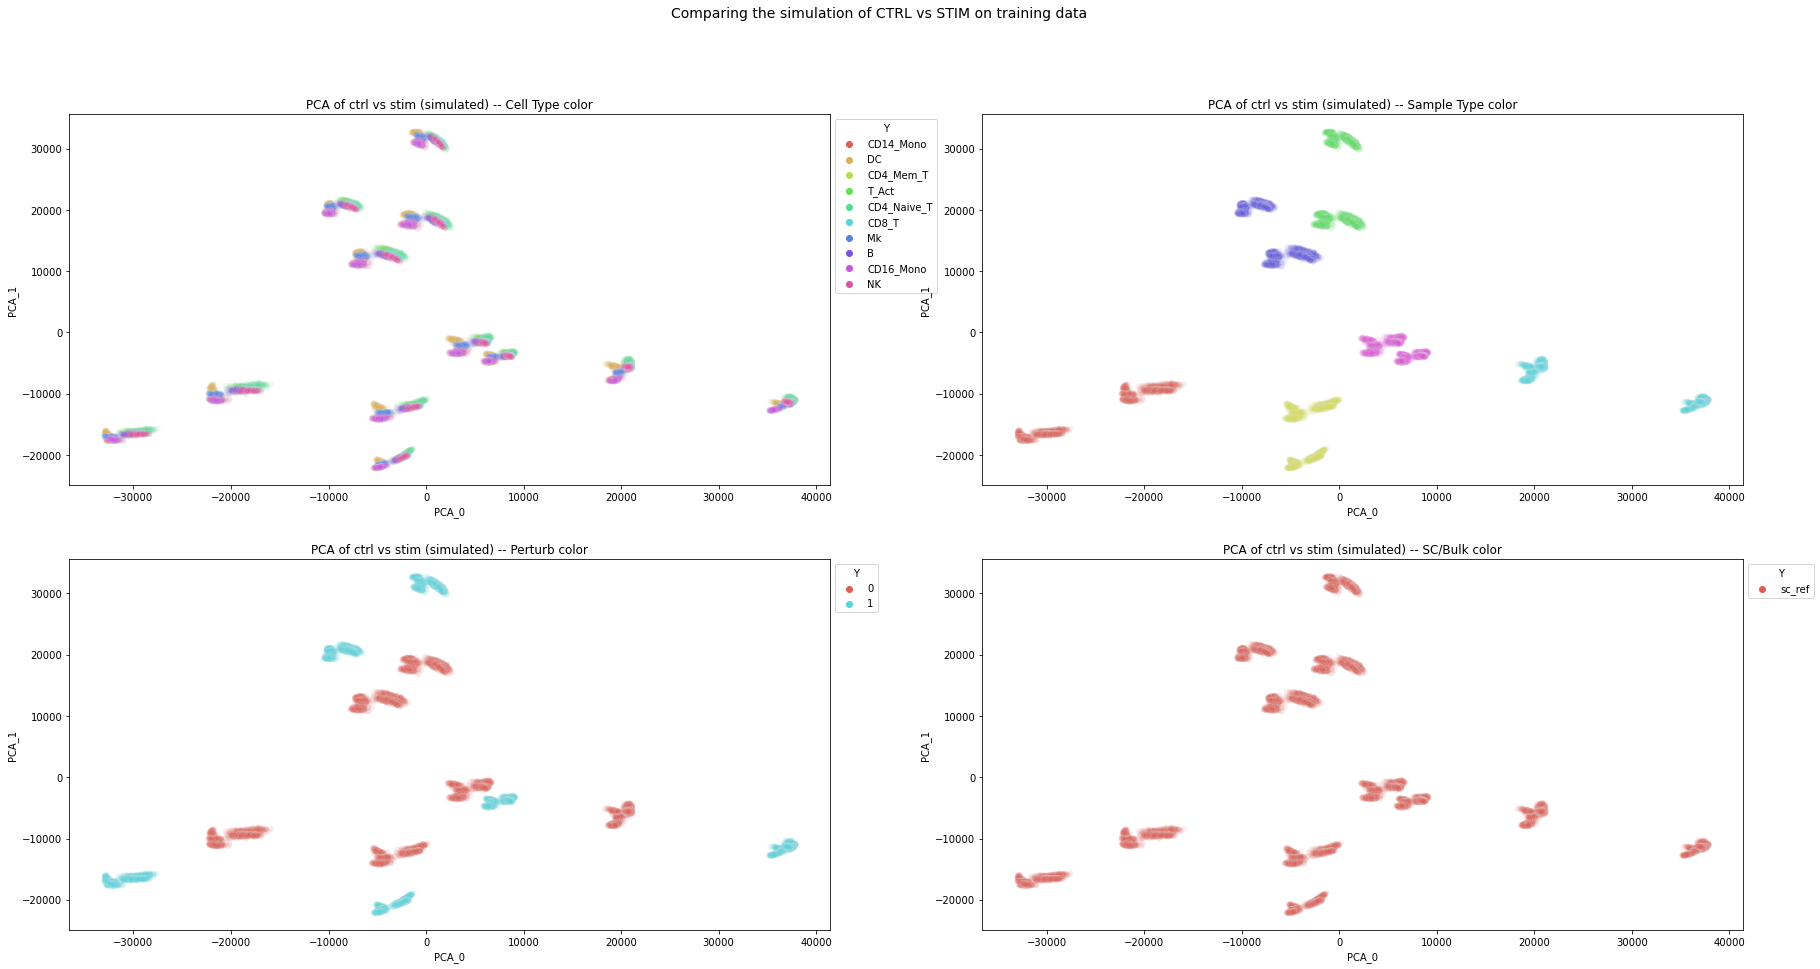

In [39]:
# make duplicated
X_dup = np.vstack([decoded_0_0, decoded_0_1])


Y_dup = np.append(sc_proj_meta_df.Y_max, sc_proj_meta_df.Y_max)


label_dup = np.append(sc_proj_meta_df.sample_id, sc_proj_meta_df.sample_id)

n_row_temp = sc_proj_meta_df.shape[0]
perturb_dup = np.asarray(np.append([0]*n_row_temp, [1]*n_row_temp))
source_dup = np.append(sc_proj_meta_df.samp_type, sc_proj_meta_df.samp_type)

fig, axs = plt.subplots(2, 2, figsize=(30,15))

plot_df = vp.get_pca_for_plotting(np.asarray(X_dup))
vp.plot_pca(plot_df, color_vec=Y_dup, ax=axs[0,0], title="PCA of ctrl vs stim (simulated) -- Cell Type color")
vp.plot_pca(plot_df, color_vec=label_dup, ax=axs[0,1], title="PCA of ctrl vs stim (simulated) -- Sample Type color")
vp.plot_pca(plot_df, color_vec=perturb_dup, ax=axs[1,0], title="PCA of ctrl vs stim (simulated) -- Perturb color")
vp.plot_pca(plot_df, color_vec=source_dup, ax=axs[1,1], title="PCA of ctrl vs stim (simulated) -- SC/Bulk color")



fig.suptitle("Comparing the simulation of CTRL vs STIM on training data", fontsize=14)
axs[0,1].legend([],[], frameon=False)

fig.show()

### plot similarities between differentially expressed genes by cell type

Here we make an UpSet plot. This plot shows the overlap of different sets. The minimum intersection set size is 5.

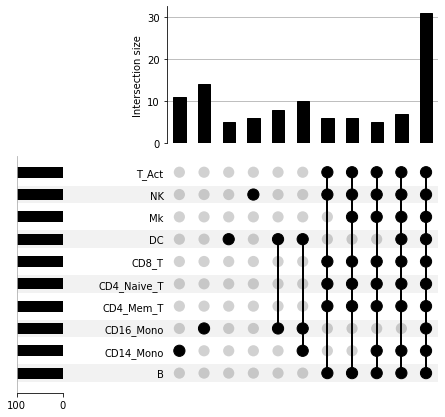

In [27]:
from scipy.stats import rankdata


top_lim = 100

top_genes = {}
de_genes_all = None
for curr_cell_type in Y_full.columns:


    # this is for the "projected" expression
    curr_idx = np.where(res_meta_df.Y_max == curr_cell_type)[0]
    proj_ctrl = decoded_0_0[curr_idx]
    proj_stim = decoded_0_1[curr_idx]

    # take the median for nomalization

    proj_ctrl = np.median(rankdata(proj_ctrl, axis=1), axis=0)
    proj_stim = np.median(rankdata(proj_stim, axis=1), axis=0)
    #proj_ctrl = np.median(proj_ctrl, axis=0)
    #proj_stim = np.median(proj_stim, axis=0)
    proj_log2FC = np.abs(proj_stim-proj_ctrl)

    # make into DF
    proj_log2FC_df = pd.DataFrame(proj_log2FC, index=union_genes)

    intersect_proj = proj_log2FC_df.loc[union_genes][0]
    top_proj_genes = intersect_proj.index[np.argsort(np.abs(intersect_proj))].tolist()[::-1][0:top_lim]

    top_genes[curr_cell_type] = top_proj_genes


cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()

#venn2([set(top_pub_genes), set(top_proj_genes)], set_labels = ('Top Pub Genes', 'Top Proj Genes'))
#plt.show()
